캐글링크 [https://www.kaggle.com/competitions/amex-default-prediction/data](https://www.kaggle.com/competitions/amex-default-prediction/data)

강사노트 [https://www.kaggle.com/code/linakeepgoing/4-amex](https://www.kaggle.com/code/linakeepgoing/4-amex)

**대회 개요**   
아메리칸 익스프레스가 2023년에 캐글에서 진행한 파산 예측 경진대회.  
실제 금융데이터 기반이며 총 4개의 파일로 구성되어 있고 크기는 50.31GB  
실습에서는 10만 개의 행을 임의로 추출하여 사용할 예정   

변수 설명   
D_* = Delinquency variables  
S_* = Spend variables  
P_* = Payment variables  
B_* = Balance variables  
R_* = Risk variables  

In [60]:
# Library
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

In [68]:
# Data Load
data_path = "../data/amex-default-prediction/train_df_sample.pkl"
df = pd.read_pickle(data_path)
df.reset_index(inplace=True)
df.head(3)

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
0,f9e9fbdc82859e7fdcea35523a78f466aa40d1bb7158da...,0.419922,0.033698,0.390381,0.449951,0.390869,0.336670,0.383050,0.000727,0.680176,...,1,U,1,1,1.0,1,1,5.0,1,1
1,824526e632f8f6c497b71cb13ec0a519be76344d472970...,0.603516,0.033983,0.542480,0.651367,0.613281,0.284424,0.238159,0.004951,0.801758,...,13,U,1,0,NaN,0,13,6.0,1,0
2,b73f63bcbb43055d5bc1b0c4365efa407a939455387a25...,0.823730,NaN,0.823730,0.823730,0.823730,0.000104,NaN,0.000104,0.000104,...,0,NaN,0,0,NaN,0,0,NaN,0,0


## Feature Engineering

한 명의 고객 단위로 `pivot`하고 10만개를 샘플링하기.  
긴 문자열은 데이터 사이즈가 클 경우 메모리 사용량에 영향을 주므로 필요한 만큼 인코딩해서 사용.  

In [69]:
import hashlib

def encode_customer_id(id_str):
    encoded_id = hashlib.sha256(id_str.encode('utf-8')).hexdigest()[:16]
    return encoded_id

df['customer_ID'] = df['customer_ID'].apply(encode_customer_id)

결측치 비율이 높은 변수는 제거하기.  
이때 해당 데이터의 결측치에는 특별한 의미 없다고 가정. (실무에서는 해당 결측치 발생 원인을 분석하는 것도 매우 중요!)  
결측치 제거하는 별도 함수 생성 or 변수 선택 부분에서 추가 or 오픈소스 라이브러리 사용. 

In [70]:
def drop_null_cols(df, threshold=0.8):
    """
    데이터프레임에서 결측치 비율이 threshold 이상인 변수를 제거하는 함수
    """
    null_percent = df.isnull().mean()
    drop_cols = list(null_percent[null_percent >= threshold].index)
    df = df.drop(drop_cols, axis=1)
    # print(f"Dropped {len(drop_cols)} columns: {', '.join(drop_cols)}")
    return df

In [71]:
df = drop_null_cols(df)

In [72]:
# 범주형 변수 지정
cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_68"]
cat_features = [f"{cf}_last" for cf in cat_features]

범주형 변수와 100개의 수치형 변수를 임의로 선택하도록 하기.

In [73]:
import random

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if 'target' not in col and col not in cat_features]
num_cols_sample = random.sample([col for col in num_cols if 'target' not in col], 100)

feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

df = df[all_list]

In [10]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [11]:
summary(df)

data shape: (100000, 111)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
D_94_mean,float16,0,0.000,2851,0.000025,1.008789,0.004036,0.082153,0.005859
D_89_last,float16,224,0.224,7293,0.0,1.005859,0.004433,0.009483,0.002254
D_58_std,float64,1110,1.110,98652,0.0,0.763094,0.013122,0.063467,NaN
D_109_mean,float16,2,0.002,2551,0.000004,1.007812,0.003704,0.004917,0.005112
D_65_std,float64,1110,1.110,98732,0.0,106.37531,0.003367,0.116218,NaN
...,...,...,...,...,...,...,...,...,...
D_126_last,float16,0,0.000,2,0.0,1.0,1.0,1.0,0.0
D_63_last,category,0,0.000,6,NaN,NaN,CO,CL,CO
D_64_last,category,1144,1.144,4,NaN,NaN,U,U,NaN
D_68_last,float16,1151,1.151,7,0.0,6.0,5.0,6.0,NaN


!! EDA 라이브러리 활용하기 !!

In [ ]:
# EDA 라이브러리 
from ydata_profiling import ProfileReport   # Report 만들기
import missingno as msno                    # 결측값 파악하기 


In [ ]:
# float16만 골라서 float64로 업캐스팅
for col in df.select_dtypes(include=["float16"]).columns:
    df[col] = df[col].astype("float64")

# 최소 리포트로 빠르게 생성
profile = ProfileReport(
    df,
    title="Report",
    minimal=True,
    explorative=False,
)

# 리포트 저장
profile.to_file("report.html")

<Axes: >

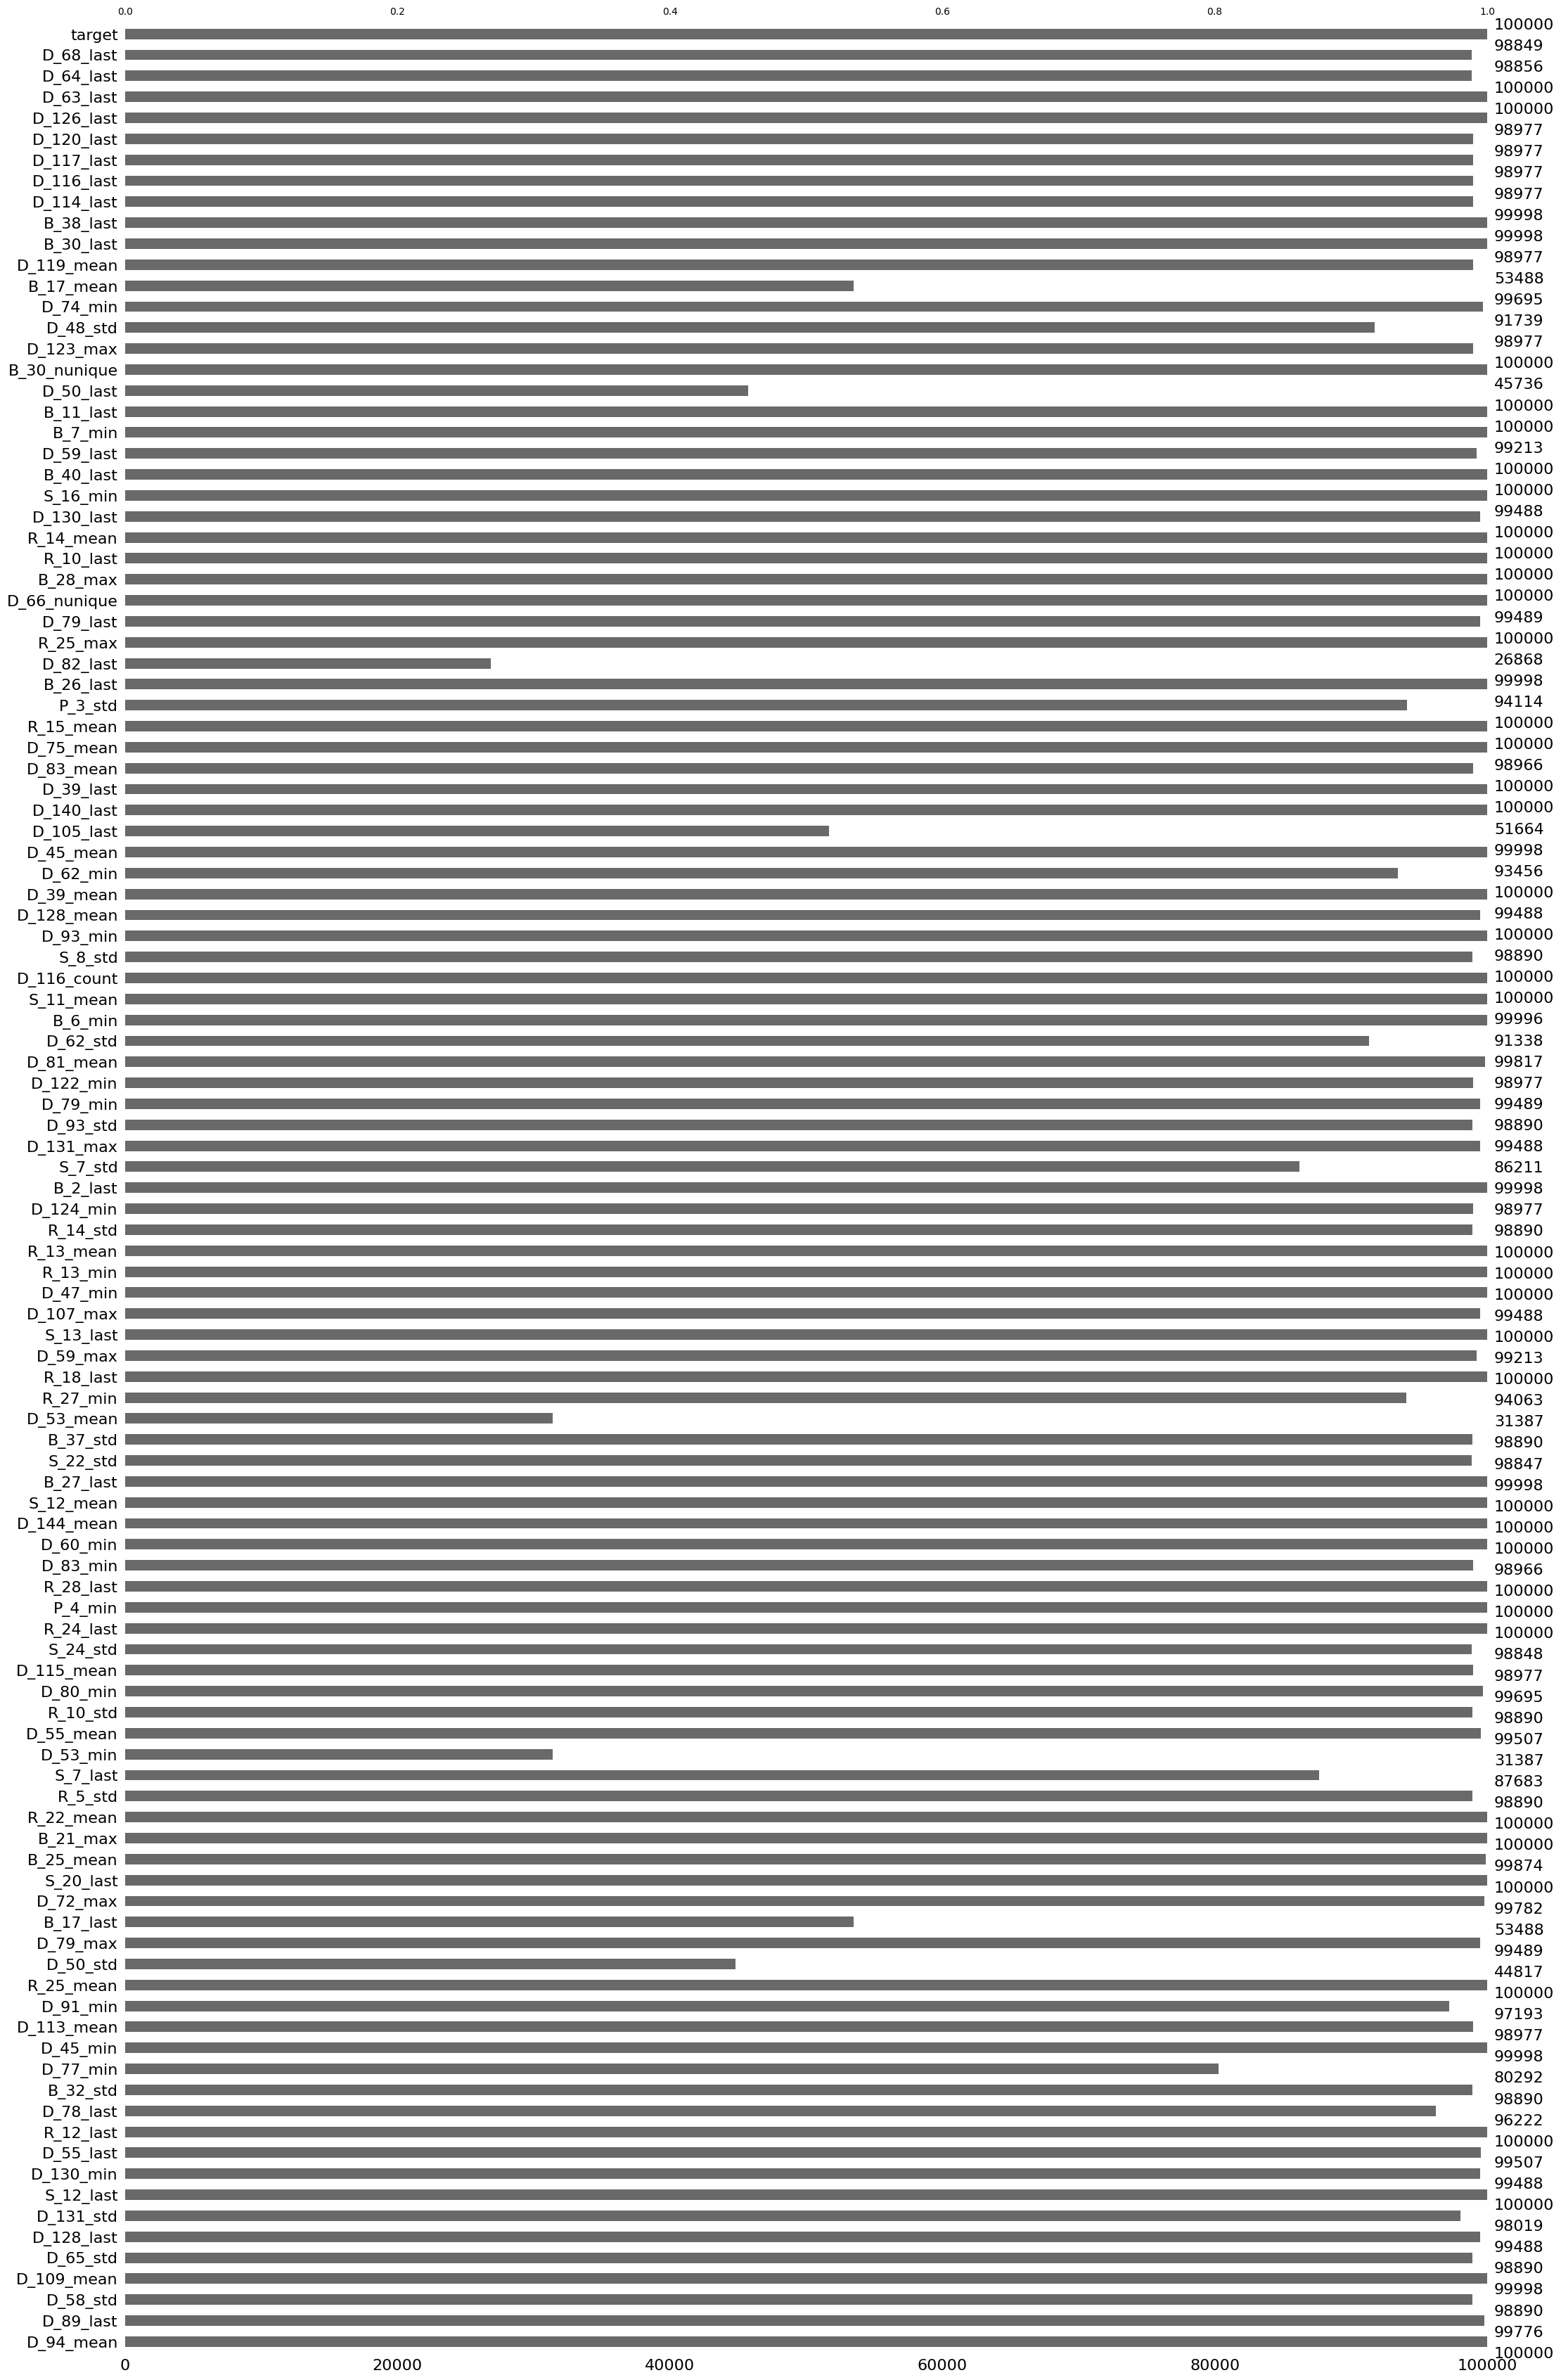

In [20]:
msno.bar(df)

**잠깐 gc time**   
gc.collect()는 파이썬의 가비지 컬렉터(Garbage Collector)를 명시적으로 호출하여 메모리를 회수하는 역할을 합니다. 가비지 컬렉터는 더 이상 사용되지 않는 객체들을 자동으로 메모리에서 해제하는 파이썬의 기능  

`gc.collect()` 호출하는 이유 :   
- 메모리 관리 : 파이썬은 동적 메모리 할당 및 해제를 처리하기 때문에, 메모리 관리가 중요. 
- 메모리 누수 방지 : 더 이상 사용되지 않는 객체들이 메모리에 남아있어 메모리 사용량이 계속 증가하지 않게 메모리에서 제거되지 않은 객체들을 강제로 회수
- 성능 개선 


일반적으로 명시적으로 호출할 필요 없음!!! 파이썬 인터프리터가 자동으로 가비지 컬렉션 수행.  
BUT 특정 시점에서 즉시 회수하고자 할 때 사용하면 좋음. 주로 대규모 테이터 차이나 장기간 실행되는 프로그램에서~

In [74]:
import gc
gc.collect()

34081

In [76]:
# 범주형 변수 타입 문자열로 통일시키기
for categorical_feature in cat_features:
    if df[categorical_feature].dtype == 'float64' or df[categorical_feature].dtype == 'float16':
        df[categorical_feature] = df[categorical_feature].astype(str)
    if df[categorical_feature].dtype == 'category':
        df[categorical_feature] = df[categorical_feature].astype(str)    
    elif df[categorical_feature].dtype == 'object':
        df[categorical_feature] = df[categorical_feature].astype(str)

In [77]:
df[cat_features].dtypes

B_30_last     object
B_38_last     object
D_114_last    object
D_116_last    object
D_117_last    object
D_120_last    object
D_126_last    object
D_63_last     object
D_64_last     object
D_68_last     object
dtype: object

결측치 처리하기.  
실무에서는 결측치 처리 시 더 다양한 탐색을 통해 처리 전략 결정해야 함.  
여기서는 평균값으로 대체 

In [78]:
from sklearn.preprocessing import LabelEncoder

le_encoder = LabelEncoder()

for categorical_feature in cat_features:
    df[categorical_feature].fillna(value='NaN', inplace=True)
    # 결측치를 하나의 고유한 값으로 지정 
    df[categorical_feature] = le_encoder.fit_transform(df[categorical_feature])

In [79]:
df[cat_features].head(5)

,B_30_last,B_38_last,D_114_last,D_116_last,D_117_last,D_120_last,D_126_last,D_63_last,D_64_last,D_68_last
0,0,4,0,0,0,1,1,1,3,5
1,0,2,0,0,4,0,1,0,3,6
2,0,0,2,2,7,2,0,1,4,7
3,0,1,1,0,5,0,1,1,1,6
4,0,1,1,0,0,0,1,0,2,6


In [80]:
from sklearn.impute import SimpleImputer

def impute_nan(df, num_cols, strategy='mean'):
    """
    NaN 값을 strategy에 따라 num_cols에 대해 impute하는 함수
    
    :param df: DataFrame
    :param num_cols: list, imputation 대상 numeric column 리스트
    :param strategy: str, imputation 전략 (default: 'mean')
    :return: DataFrame, imputed DataFrame
    """
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df

In [81]:
df = impute_nan(df,num_cols_sample, strategy="mean")

### 시각화

In [42]:
import plotly.express as px

fig2 = px.pie(df, names='target', 
             height=400, width=600, 
             hole=0.7, 
             title='target class Overview',
                   color_discrete_sequence=['#4c78a8', '#72b7b2'])
fig2.update_traces(hovertemplate=None, textposition='outside', textinfo='percent+label', rotation=0)
fig2.update_layout(margin=dict(t=100, b=30, l=0, r=0), showlegend=False,
                        plot_bgcolor='#fafafa', paper_bgcolor='#fafafa',
                        title_font=dict(size=20, color='#555', family="Lato, sans-serif"),
                        font=dict(size=17, color='#8a8d93'),
                        hoverlabel=dict(bgcolor="#444", font_size=13, font_family="Lato, sans-serif"))
fig2.show()

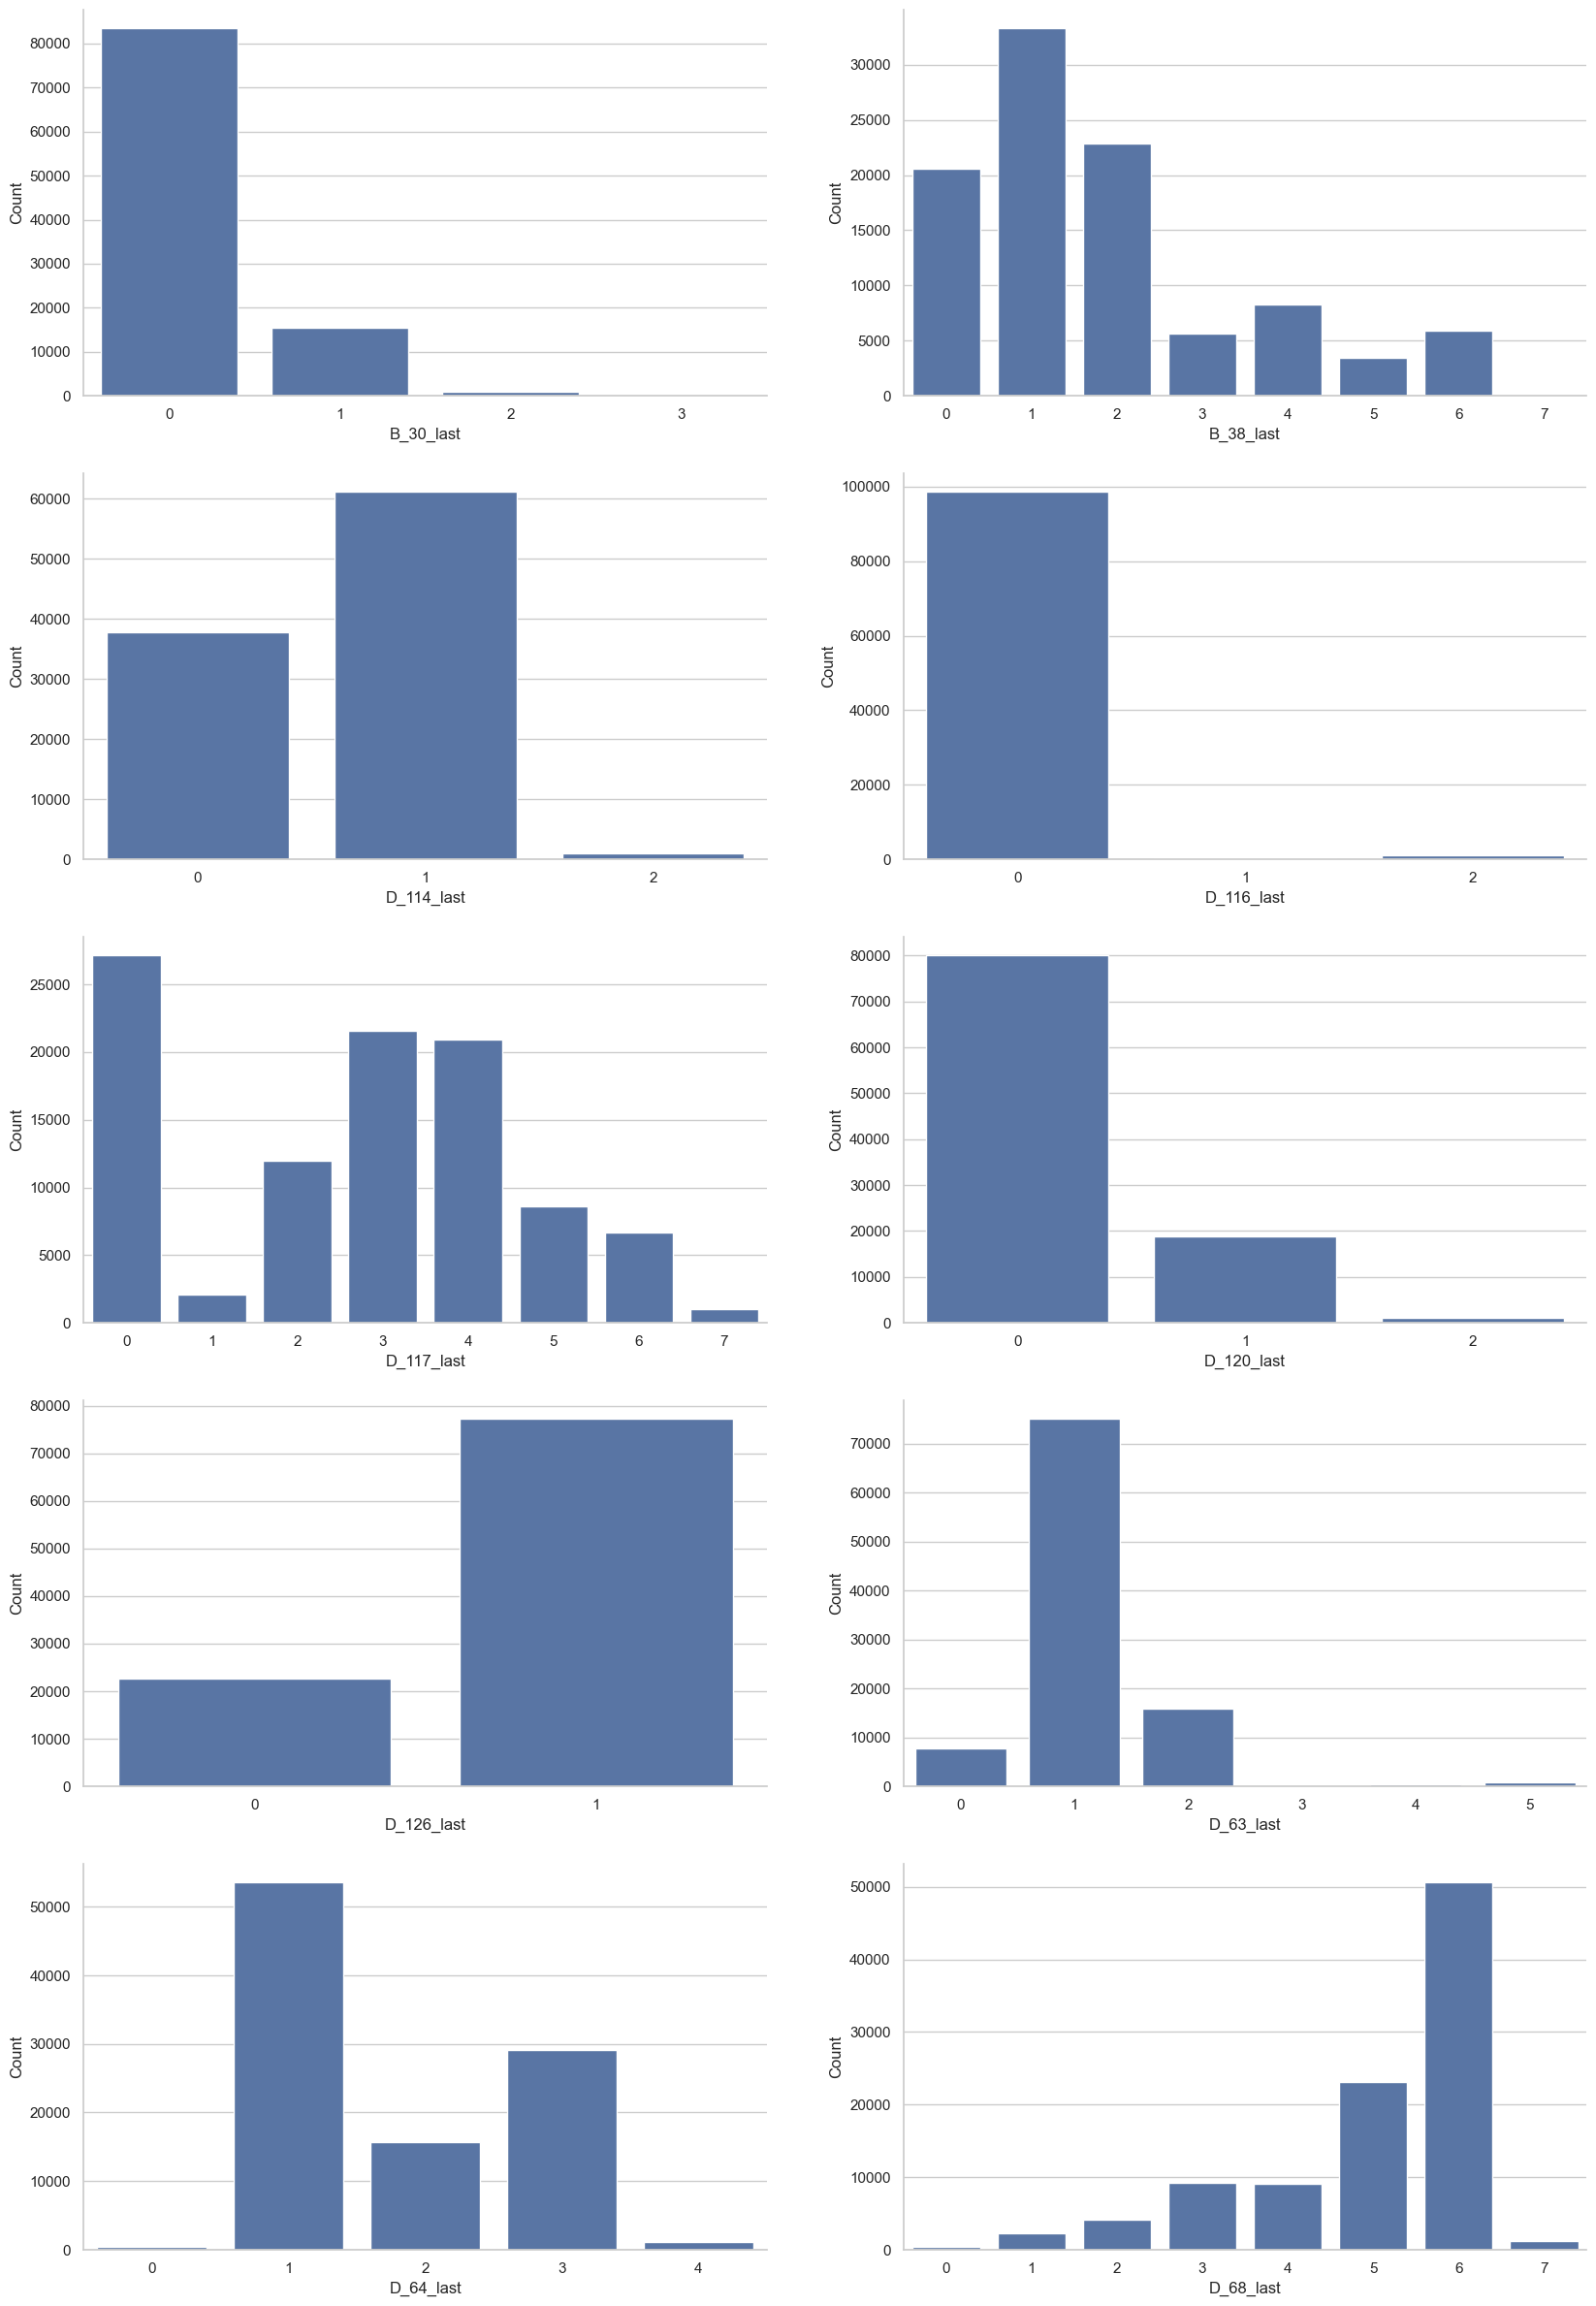

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_theme(style="whitegrid")
fig, axs = plt.subplots(math.ceil(len(cat_features)/2), 2, figsize=(20, 30))
for i, feature in enumerate(cat_features):
    row = i // 2
    col = i % 2
    sns.countplot(x=feature, data=df, ax=axs[row, col])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel("Count")
    sns.despine()
plt.show()

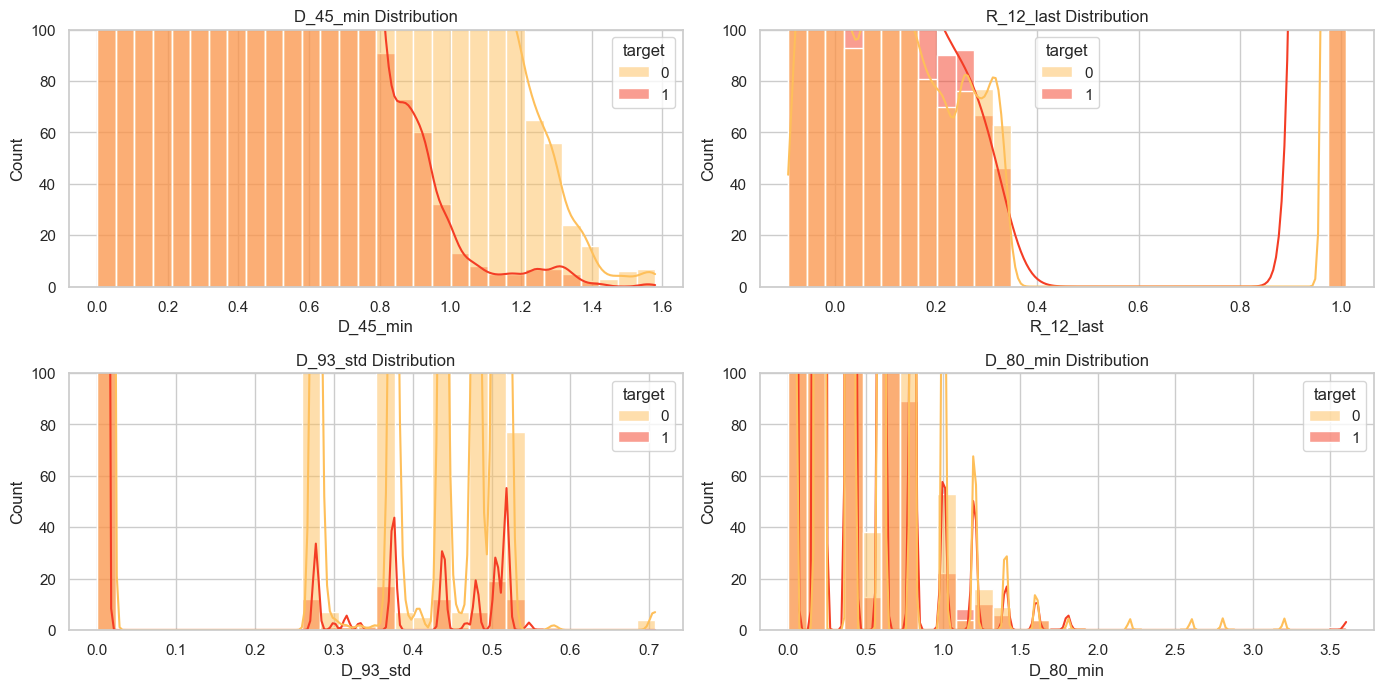

In [46]:
exp_cols = random.sample(num_cols_sample, k=4)
# num_data = train_data.select_dtypes(exclude=['object']).copy()

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="target", data=df,bins=30,kde=True,palette='YlOrRd')
    plt.title(f"{column} Distribution")
    plt.ylim(0,100)
    plt.tight_layout()

#### WOE 와 IV 계산 함수 

In [36]:
def calculate_woe_iv(df, feature_list, cat_features, target):
    '''
    1. 피처가 범주형일 경우 : 해당 피처의 고유값들을 bin으로 사용
    2. 피처가 연속형일 경우 : 10개의 bin으로 분할하고 bin 경계값을 저장
    3. 각 bin에서 이벤트와 비이벤트(이벤트 발생x)의 개수 계산
    4. 비이벤트와 이벤트의 비율 계산
    5. WoE 계산
    6. IV 계산
    7. IV 합이 0.02 이상인 경우 피처를 선택된 피처 목록에 추가
    8. result_df에 WOE, IV 값 추가
    9. WoE 값을 피처별로 저장하는 woe_dict에도 저장
    
    '''
    result_df = pd.DataFrame(columns=['Feature', 'Bins', 'WOE', 'IV', 'IV_sum'])
    selected_features = []  # 선택된 피처들을 저장할 리스트
    bin_edges_dict = {}  # 피처별 bin 경계값을 저장할 딕셔너리
    woe_dict = {}  # 피처별 WOE 값을 저장할 딕셔너리

    for feature in feature_list:
        if feature in cat_features:  # 피처가 범주형일 경우
            df_temp = df.copy()
            df_temp[feature + '_bins'] = df_temp[feature]  # 범주형 변수의 고유값들을 bin으로 사용
            bin_edges_dict[feature] = sorted(df[feature].unique())  # 피처의 고유값들을 bin 경계값으로 저장
        else:  # 피처가 연속형일 경우
            df_temp = df.copy()
            df_temp[feature + '_bins'], bin_edges = pd.qcut(df_temp[feature], 10, duplicates='drop', retbins=True)
            bin_edges_dict[feature] = bin_edges  # 피처를 10개의 bin으로 분할하고 bin 경계값을 저장

        # 피처의 각 bin에서 이벤트와 비이벤트의 개수를 계산합니다.
        grouped_data = df_temp.groupby(feature + '_bins')[target].agg([
            ('non_event', lambda x: sum(1 - x)),  # 비이벤트(0)의 개수를 합산
            ('event', lambda x: sum(x))  # 이벤트(1)의 개수를 합산
        ]).reset_index()

        # 비이벤트와 이벤트의 비율을 계산합니다.
        grouped_data['non_event_prop'] = grouped_data['non_event'] / sum(grouped_data['non_event'])
        grouped_data['event_prop'] = grouped_data['event'] / sum(grouped_data['event'])

        # WOE(Weight of Evidence)를 계산합니다.
        grouped_data['WOE'] = np.where(
            grouped_data['event_prop'] == 0,
            0,
            np.log(grouped_data['non_event_prop'] / grouped_data['event_prop'])
        )

        # Information Value(IV)를 계산합니다.
        grouped_data['IV'] = (grouped_data['non_event_prop'] - grouped_data['event_prop']) * grouped_data['WOE']
        iv_sum = sum(grouped_data['IV'])

        if iv_sum >= 0.02:  # IV 합이 0.02 이상인 경우 피처를 선택
            selected_features.append(feature)

        result = pd.DataFrame()
        result['Feature'] = [feature] * len(grouped_data)
        result['Bins'] = grouped_data[feature + '_bins']
        result['WOE'] = grouped_data['WOE']
        result['IV'] = grouped_data['IV']
        result['IV_sum'] = [iv_sum] * len(grouped_data)

        result_df = pd.concat([result_df, result])

        woe_dict[feature] = grouped_data.set_index(feature + '_bins')['WOE'].to_dict()

    # 선택된 피처들의 개수와 목록을 출력합니다.
    print("전체 피처 개수:", len(feature_list))
    print("선택된 피처 개수:", len(selected_features))
    print("선택된 피처:", selected_features)

    return result_df, selected_features, bin_edges_dict, woe_dict

In [82]:
result_df, selected_features, bin_edges_dict, woe_dict = calculate_woe_iv(df,  feature_list, cat_features, 'target')

전체 피처 개수: 110
선택된 피처 개수: 96
선택된 피처: ['R_19_max', 'D_107_last', 'R_8_mean', 'B_16_min', 'P_3_max', 'R_6_std', 'D_61_last', 'R_10_min', 'D_84_min', 'D_112_min', 'D_41_max', 'D_59_mean', 'S_16_min', 'D_104_max', 'D_141_std', 'D_62_min', 'D_77_mean', 'R_16_mean', 'R_1_max', 'B_11_std', 'B_25_max', 'R_13_max', 'S_5_std', 'S_13_mean', 'D_119_max', 'D_124_last', 'B_1_last', 'S_16_std', 'B_19_min', 'R_16_min', 'R_6_mean', 'D_125_last', 'B_28_min', 'D_74_std', 'D_140_max', 'B_38_count', 'D_71_last', 'D_62_std', 'D_81_max', 'S_11_mean', 'S_7_std', 'B_3_std', 'D_112_last', 'D_54_last', 'R_11_mean', 'B_20_max', 'D_129_mean', 'B_13_std', 'D_71_std', 'D_42_mean', 'D_43_last', 'B_1_std', 'S_25_last', 'D_122_max', 'S_23_min', 'D_41_mean', 'D_56_mean', 'R_16_last', 'R_21_std', 'B_14_std', 'S_25_max', 'D_61_std', 'S_25_min', 'D_55_max', 'D_131_last', 'S_15_max', 'B_21_mean', 'S_3_mean', 'S_5_mean', 'S_12_last', 'D_50_std', 'D_128_max', 'D_59_last', 'B_12_last', 'D_112_std', 'D_75_min', 'S_3_last', 'D_11

In [83]:
def transform_to_woe(df, selected_features, cat_features, bin_edges_dict, woe_dict, target):
    df_woe = df[selected_features + [target]].copy()

    for feature in selected_features:
        if feature in cat_features:
            # 범주형 피처의 경우, 해당 피처의 WOE 값을 매핑합니다.
            df_woe[feature] = df_woe[feature].map(woe_dict[feature])
        else:
            # 연속형 피처의 경우, bin 경계값에 따라 WOE 값을 할당합니다.
            feature_bins = pd.cut(df_woe[feature], bins=bin_edges_dict[feature], include_lowest=True)
            df_woe[feature] = feature_bins.map(woe_dict[feature])

    return df_woe

In [84]:
df_woe = transform_to_woe(df, selected_features, cat_features, bin_edges_dict, woe_dict, 'target')

In [85]:
df_woe.head()

,R_19_max,D_107_last,R_8_mean,B_16_min,P_3_max,R_6_std,D_61_last,R_10_min,D_84_min,D_112_min,...,B_4_max,B_30_last,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last,target
0,0.097906,-0.063259,-0.014439,1.005740,-0.033812,0.419914,-1.481095,-0.033882,-0.112208,-0.050255,...,1.344878,0.469073,-1.408741,-0.508513,-0.192825,-0.956754,-0.064498,-0.489751,-0.110150,1
1,-0.390071,0.307707,0.341419,1.005740,0.270541,0.419914,-0.867367,-0.520327,0.195995,0.349965,...,-0.717424,0.469073,-0.394101,-0.508513,0.421929,0.291743,-0.249478,-0.489751,0.451170,0
2,-0.187376,-0.063259,-0.014439,1.167018,-0.033812,-2.099401,2.354791,-0.520327,-0.634520,-0.050255,...,1.344878,0.469073,1.277605,-0.371257,-0.371257,-0.371257,-0.064498,-0.359813,-0.338898,0
3,0.097277,0.307707,0.426958,1.097521,-0.033812,0.419914,2.896701,0.079483,0.078677,0.349965,...,0.996470,0.469073,1.873590,0.393672,0.751712,0.291743,-0.064498,0.474475,0.451170,0
4,-0.390071,0.306970,0.405720,0.457804,0.270541,0.419914,2.799622,-0.520327,0.154002,0.349965,...,1.762197,0.469073,1.873590,0.393672,-0.192825,0.291743,-0.249478,-0.371087,0.451170,0


## Modeling
XGBoost 사용 / 하이퍼 파라미터 튜닝 (x)

In [47]:
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

def xgboost_model(df_woe, target, folds=5, seed=2023):
    xgb_models = []  # XGBoost 모델들을 저장할 리스트
    xgb_oof = []  # out-of-fold 예측 결과를 저장할 리스트
    predictions = np.zeros(len(df_woe))  # 전체 데이터셋에 대한 예측 결과를 저장할 배열
    f_imp = []  # 특성 중요도를 저장할 리스트

    X = df_woe.drop(columns=[target])  # 독립 변수 데이터
    y = df_woe[target]  # 종속 변수 데이터

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
        watchlist = [(X_train, y_train), (X_valid, y_valid)]

        model = XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2,  early_stopping_rounds=300, colsample_bytree=0.67)
        model.fit(X_train, y_train, eval_set=watchlist,verbose=0)

        val_preds = model.predict_proba(X_valid)[:, 1]  # 검증 세트에 대한 예측 확률
        val_score = roc_auc_score(y_valid, val_preds)  # 검증 세트의 ROC AUC 점수
        best_iter = model.best_iteration

        idx_pred_target = np.vstack([val_idx, val_preds, y_valid]).T  # 검증 세트 인덱스, 예측 확률, 실제 타겟 값으로 구성된 배열
        f_imp.append({i: j for i, j in zip(X_train.columns, model.feature_importances_)})  # 특성 중요도 저장

        print(f'{" "*20} auc:{val_score:.5f} {" "*6} best iteration:{best_iter}')

        xgb_oof.append(idx_pred_target)  # out-of-fold 예측 결과 추가
        xgb_models.append(model)  # 학습된 모델 추가

        if val_score > 0.917:
            predictions += model.predict_proba(X)[:, 1]  # 특정 조건을 만족하는 모델의 예측 확률을 누적

    predictions /= folds  # folds 수로 나눠 평균 예측 확률 계산
    mean_val_auc = np.mean([roc_auc_score(oof[:, 2], oof[:, 1]) for oof in xgb_oof])  # 평균 out-of-fold ROC AUC 점수 계산
    print('*'*45)
    print(f'Mean AUC: {mean_val_auc:.5f}')

    return xgb_models, xgb_oof, predictions, f_imp

XGB 모델에 적합하도록 category 변수 변환하기

In [86]:
def convert_category_to_numeric(df):
    for col in df.columns:
        if str(df[col].dtype) == 'category':
            df[col] = df[col].astype('int')
    return df

df_woe = convert_category_to_numeric(df_woe)

In [87]:
xgb_models, xgb_oof, predictions, f_imp = xgboost_model(df_woe, 'target', folds=5, seed=2023)

######################## Training FOLD 1 ########################
                     auc:0.94677        best iteration:159
######################## Training FOLD 2 ########################
                     auc:0.94677        best iteration:125
######################## Training FOLD 3 ########################
                     auc:0.94625        best iteration:119
######################## Training FOLD 4 ########################
                     auc:0.94810        best iteration:116
######################## Training FOLD 5 ########################
                     auc:0.94644        best iteration:130
*********************************************
Mean AUC: 0.94687


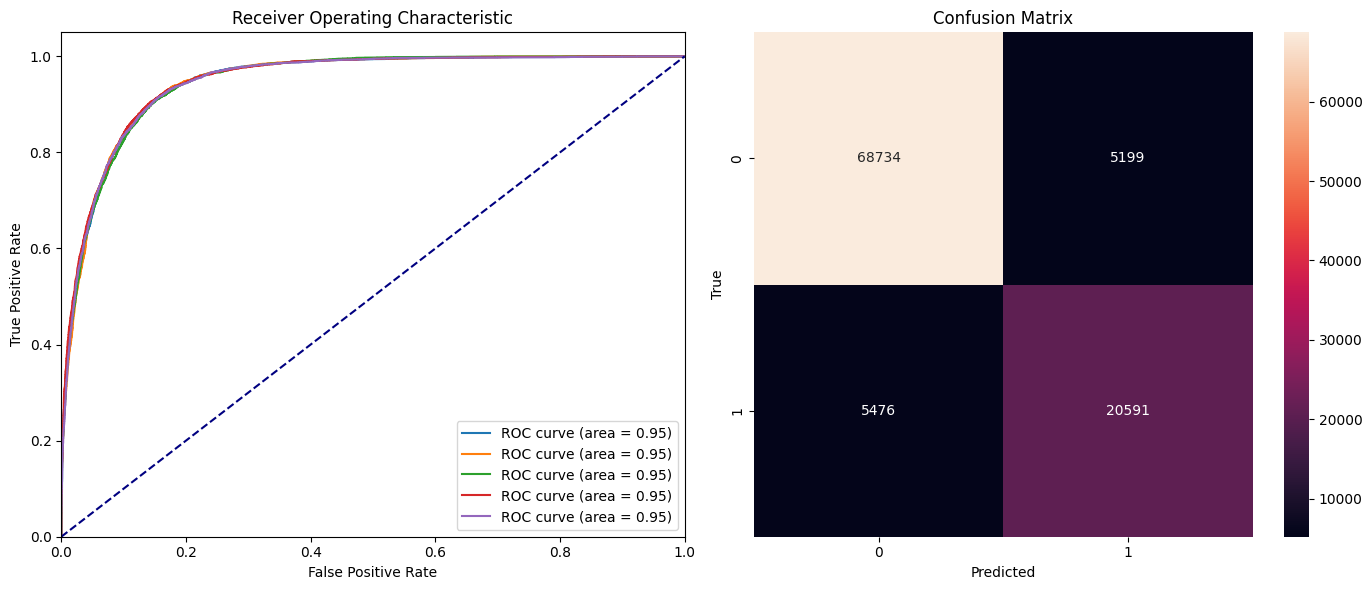

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

plt.figure(figsize=(14, 6))

# Plot ROC curves
plt.subplot(1, 2, 1)
for oof in xgb_oof:
    fpr, tpr, _ = roc_curve(oof[:, 2], oof[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Compute and plot confusion matrix
plt.subplot(1, 2, 2)
# 혼동 행렬(Confusion Matrix)을 계산하고 그립니다.
# 확률 대신 예측 클래스를 사용해야 합니다.
# 예측 임계값으로 0.5를 사용합니다.
predictions_class = [1 if pred > 0.5 else 0 for pred in predictions]
cm = confusion_matrix(df_woe['target'], predictions_class)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

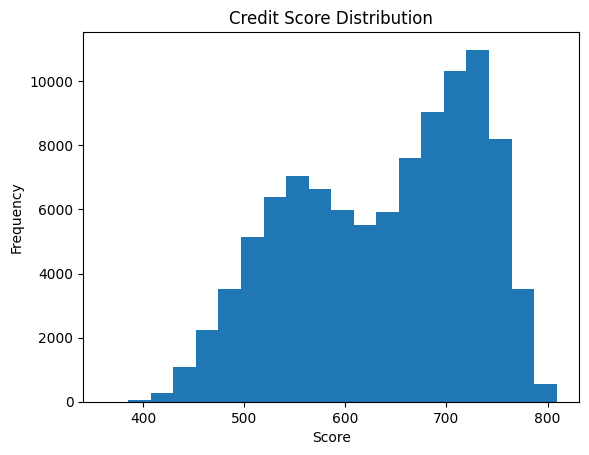

In [ ]:
# Define the base score 
base_score = 650

# Define the PDO (Point of double) -> 확률의 로그 오즈가 2배가 될 떄 점수가 20점 증가 
PDO = 20

# Calculate the factor and offset
factor = PDO / np.log(2)
offset = base_score - (factor * np.log(20))

# Define a function to calculate the score
def calculate_score(probability, factor, offset):
    odds = (probability / (1 - probability))
    score = offset + (factor * np.log(odds))
    return np.clip(score, 250, 1000)  # Clip scores between 250 and 1000(신용점수범위 지정)

# Calculate the scores
scores = calculate_score(1 - predictions, factor, offset)

# Round the scores to the nearest integer
scores = np.round(scores)

# Plot the score distribution -> 신용점수 분포 시각화
plt.hist(scores, bins=20)
plt.title('Credit Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [95]:
# Add the predictions and scores to the dataframe
df_woe['probability'] = predictions
df_woe['credit_score'] = scores

# Select 5 random samples
samples = df_woe.sample(5, random_state=42)

# Display the samples
samples

,R_19_max,D_107_last,R_8_mean,B_16_min,P_3_max,R_6_std,D_61_last,R_10_min,D_84_min,D_112_min,...,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last,target,probability,credit_score
75721,0,0,0,0,0,0,0,0,0,0,...,-0.394101,0.393672,-0.192825,0.291743,0.505683,-0.489751,-0.110150,0,0.110733,624.0
80184,0,0,0,0,0,0,-2,0,0,0,...,-1.804870,0.393672,-0.128533,0.291743,-0.064498,-0.489751,-0.509633,1,0.260420,594.0
19864,0,0,0,0,0,0,1,0,0,0,...,1.277605,0.393672,-0.192825,0.291743,-0.064498,0.474475,-0.110150,0,0.013040,688.0
76699,0,0,0,0,0,0,2,0,0,0,...,1.873590,-0.508513,0.741034,0.291743,-0.064498,-0.489751,-0.110150,0,0.026739,667.0
92991,0,0,0,1,0,0,-1,0,0,0,...,1.277605,-0.508513,0.421929,-0.956754,-0.064498,-0.489751,-0.714214,0,0.694586,540.0


## Inference

In [96]:
def predict_and_score(model, instance, factor, offset):
    # Reshape the instance if it's a series/single row
    if len(instance.shape) == 1:
        instance = instance.values.reshape(1, -1)

    # Make prediction
    probability = model.predict_proba(instance)[:, 1]

    # Calculate score
    score = calculate_score(1 - probability, factor, offset)

    # Round the score to the nearest integer
    score = np.round(score)

    return score[0]


In [97]:
inference = df_woe.drop(['target','probability','credit_score'], axis=1)

In [98]:
inference.sample(1)

,R_19_max,D_107_last,R_8_mean,B_16_min,P_3_max,R_6_std,D_61_last,R_10_min,D_84_min,D_112_min,...,D_77_max,B_4_max,B_30_last,B_38_last,D_114_last,D_117_last,D_120_last,D_63_last,D_64_last,D_68_last
1965,0,0,-2,1,-1,0,-2,0,0,0,...,-1,0,0.469073,-1.408741,0.393672,-0.128533,-0.956754,-0.064498,0.474475,-0.714214


In [99]:
# Extract one sample from the data
sample = inference.sample(1)

# Call the function with the first trained model and the sample data
score = predict_and_score(xgb_models[0], sample, factor, offset)
print("해당 고객의 신용 점수는 다음과 같습니다: ", score)

해당 고객의 신용 점수는 다음과 같습니다:  674.0


## 추가 : K-S 통계값 계산하기 

In [ ]:
def calculate_ks(actual, predicted):
    pairs = zip(actual, predicted)
    sorted_pairs = sorted(pairs, key=lambda x: x[1], reverse=True)

    num_positive = sum(1 for actual, _ in sorted_pairs if actual == 1)
    cum_positive_ratio = 0
    max_ks = 0
    max_threshold = 0

    for i, (actual, predicted) in enumerate(sorted_pairs):
        if actual == 1:
            cum_positive_ratio += 1 / num_positive
        else:
            cum_negative_ratio = (i + 1 - cum_positive_ratio) / (len(sorted_pairs) - num_positive)

            current_ks = abs(cum_positive_ratio - cum_negative_ratio)
            if current_ks > max_ks:
                max_ks = current_ks
                max_threshold = predicted

    return max_ks, max_threshold